# Theano

Theano is a python library and an optimizing compiler, which allows to define, optimize and compute mathematical expressions effectively using multidimensional arrays.

This notebook requires theano (`!pip install theano`) and `gcc` (if you're using windows, it's not that simple).

Also, install `hep_ml` (`!pip install hep_ml`) if you haven't done this yet.

Theano features:

* integration with `NumPy`
* effective analytical computation of gradient (can automatically build expressions to compute gradient)
* fast and stable optimization (can recognize numerical inaccurate expressions and compute them using more stable algorithms)
* transparent usage of GPU
* dynamic C++ code generation

In [184]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy

## Import 

In [185]:
# next line is a convention
import theano.tensor as T
import theano

## Symbolic expessions for tensors
Theano’s strength is in expressing symbolic calculations involving tensors. There are many types of symbolic expressions for tensors:

* scalar
* vector
* matrix
* tensor
* ...

In [186]:
# create two vectors and one scaler. Those are abstract variables
x = T.vector() 
y = T.vector()
alpha = T.scalar()

#### compute 
$x + \alpha y + (\sum x_i, ... ,\sum x_i)^T$

In [4]:
# define mathematical expression (you can use any function, which you use for NumPy arrays). 
z = x + alpha * y + T.sum(x)

## Compile defined expression
`theano.function`

Returns a callable object that will calculate outputs from inputs

In [5]:
# input variables, output expessions
compiled_expr = theano.function([x, y, alpha], z)

## Compute compiled expression

In [6]:
x_val = numpy.arange(10)
y_val = numpy.arange(10)
alpha_val = 0.5

In [7]:
compiled_expr(x_val, y_val, alpha_val)

array([ 45. ,  46.5,  48. ,  49.5,  51. ,  52.5,  54. ,  55.5,  57. ,  58.5])

## Exercises

In [8]:
# create two vectors and two scalars
x = T.vector() 
y = T.vector()
alpha = T.scalar()
beta = T.scalar()

# define values for each variable 
x_val = numpy.arange(10)
y_val = numpy.arange(10)
alpha_val = 0.1
beta_val = 0.3

* compute $z = (x_1 + y_1^2, x_2 + y_2^2, ...)^T$: define theano function and evaluate it

In [14]:
z = x+y**2

In [15]:
compiled_expr = theano.function([x, y], z)

In [16]:
compiled_expr(x_val, y_val)

array([  0.,   2.,   6.,  12.,  20.,  30.,  42.,  56.,  72.,  90.])

* compute $||x||$

In [216]:
x = T.vector()
z = T.dot(x, x)
compiled_expr = theano.function([x], T.sqrt(z))
compiled_expr([3, 4, 0])

array(5.0)

In [189]:
z = T.sqrt(T.sum(x*x))

In [190]:
compiled_expr = theano.function([x], z)

In [191]:
compiled_expr([3, 4, 0])

array(5.0)

* compute $(<x, \alpha y> + <\beta x, y>)^2$

In [192]:
z = T.dot(x, alpha*y) + T.dot(beta*x, y)

In [193]:
compiled_expr = theano.function([alpha, beta, x, y], z**2)

In [194]:
compiled_expr(1, 2, [3], [4])

array(1296.0)

## Names for variables

In [195]:
# define 
x = T.vector(name='x')
y = T.vector(name='y')
alpha = T.scalar(name='a')

In [196]:
z = alpha * x * T.log(y) 

### `theano.printing.pprint()`
Theano provides the functions `theano.printing.pprint()` and `theano.printing.debugprint()` to print a graph to the terminal before or after compilation. `pprint()` is more compact and math-like, `debugprint()` is more verbose. Theano also provides `pydotprint()` that creates an image of the function. 

In [197]:
theano.pprint(x)

'x'

In [198]:
theano.pprint(z)

'((a * x) * log(y))'

In [199]:
compiled_expr = theano.function(inputs=[x, y, alpha], outputs=[z], name='function')

In [200]:
theano.printing.debugprint(compiled_expr)

Elemwise{Composite{(log(i0) * i1 * i2)}} [@A] ''   1
 |y [@B]
 |InplaceDimShuffle{x} [@C] ''   0
 | |a [@D]
 |x [@E]


The output file is available at graph.png


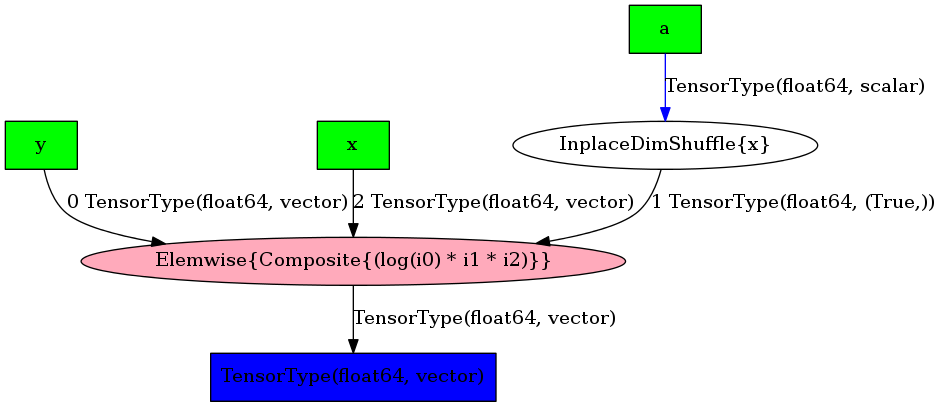

In [201]:
theano.printing.pydotprint(compiled_expr, outfile="graph.png", var_with_name_simple=True)
Image('./graph.png')

## Gradient

`T.grad` computes symbolic gradients for one or more variables with respect to some cost.

### 1D gradient (derivative)

In [46]:
x = T.scalar(name='x') 
function1d = x ** 2 + T.log(x)
function1d_derivative = T.grad(function1d, x)

In [47]:
# result of analytical differentiation:
theano.pprint(function1d_derivative)

'(((fill(((x ** TensorConstant{2}) + log(x)), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1}))) + (fill(((x ** TensorConstant{2}) + log(x)), TensorConstant{1.0}) / x))'

In [48]:
# let's compile it
compiled_derivative = theano.function([x], function1d_derivative)

In [49]:
# optimizations were done during compilation
theano.printing.debugprint(compiled_derivative)

Elemwise{Composite{((i0 * i1) + inv(i1))}} [@A] ''   0
 |TensorConstant{2.0} [@B]
 |x [@C]


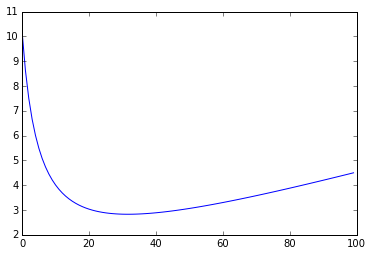

In [50]:
x = numpy.linspace(0.1, 2, 100)
plt.plot([compiled_derivative(point) for point in x])

### NDimensional gradient

In [51]:
x = T.vector(name='x') 
function = T.sum(x * x)
function_gradient = T.grad(function, x)

In [52]:
compiled_gradient = theano.function([x], function_gradient)

In [53]:
compiled_gradient([1, 2, 4, 0])

array([ 2.,  4.,  8.,  0.])

In [54]:
theano.printing.debugprint(compiled_gradient)

Elemwise{add,no_inplace} [@A] ''   0
 |x [@B]
 |x [@B]


## Shared variables
`theano.shared` returns a SharedVariable variable, initialized with a copy or reference of `value`.

Variable with Storage that is shared between functions that it appears in. These variables are meant to be created by registered shared constructors, i.e. `shared()`

In [205]:
w = theano.shared(numpy.arange(10, dtype=float), name='weight')

In [211]:
print w, w.get_value()

weight [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


In [208]:
x = T.vector('x')
# dotproduct = theano.function([x], T.sum(x * w))
dotproduct_grad = theano.function([x], T.grad(T.sum(x * w), x))

In [209]:
dotproduct_grad(numpy.arange(10) * 0.)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [210]:
dotproduct_grad(numpy.arange(10) * 10.)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

## Matrix

#### Compute $||Ax||^2$:

In [219]:
x = T.vector()
A = T.matrix()
z = T.dot(A*x, A*x)
fun = theano.function([x, A], z)
normAx([0, 2], [[1, 1], [1, 1]])

array(8.0)

In [220]:
x = T.vector('x')
A = T.matrix('A')
z = A.dot(x)
normAx = theano.function([x, A], z.dot(z))
normAx([0, 2], [[1, 1], [1, 1]])

array(8.0)

## Exercises

* compile a function which takes an array $x$ with three elements and computes $x_0^3 + \sin{x_1}*\cos{x_2}$. Check it by computing at any point

In [118]:
x = T.vector('x')

z = x[0]**3 + T.sin(x[1]) * T.cos(x[2])

In [119]:
compiled_fun = theano.function([x], z)

In [120]:
x = [2, 1, 1]

In [121]:
compiled_fun(x)

array(8.45464871341284)

* compute gradient for previous function w.r.t. x

In [123]:
x = T.vector('x')

z = x[0]**3 + T.sin(x[1]) * T.cos(x[2])
function_derivative = T.grad(z, x)

compiled_gradient = theano.function([x], function_derivative)

In [124]:
compiled_gradient([2,1,1])

array([ 12.        ,   0.29192658,  -0.70807342])

* compute gradient for $||Ax|| + \alpha * ||x||$ 

In [227]:
x = T.vector('x')
A = T.scalar('A')
alpha = T.scalar('alpha')
z = T.sqrt(T.dot(A*x, A*x)) + alpha*T.sqrt(T.dot(x, x))

function_derivative = T.grad(z, x)

compiled_gradient = theano.function([alpha, A, x], function_derivative)

In [228]:
A = [0, 1, 2, 3, 4]
x = [0, 1, 2, 3, 4]
alpha = 2

In [229]:
compiled_gradient(alpha, A, x)

TypeError: ('Bad input argument to theano function with name "<ipython-input-227-88dbc61d1790>:8"  at index 1(0-based)', 'Wrong number of dimensions: expected 0, got 1 with shape (5,).')

# Logistic regression 

In [230]:
# import function to create toy dataset for classification
from sklearn.datasets import make_blobs, make_moons
from sklearn.cross_validation import train_test_split 
from sklearn.metrics import roc_auc_score
# logistic function (we introduce shortcut sigmoid)
from scipy.special import expit as sigmoid

### generate toy samples

In [231]:
n_features = 10 # number of features
centers = 2 # number of classes
X, y = make_blobs(n_samples=10000, centers=centers, n_features=n_features, random_state=42)
trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.5, random_state=42)

## Logistic regression description:

$p_i = \sigma(\sum_k X_{ik} w_k)$

$\text{llh}=\sum_i y_i \log{p_i} + (1-y_i)\log{(1 - p_i)}\qquad$  (here $y \in \{0, 1\}$)

$loss = -\text{llh}, \qquad loss \to \min$

## Exercise 

Write loss function and its gradient using theano (create compiled expressions).

**Use** `T.nnet.sigmoid`

In [243]:
# create theano objects for data(they should be shared because we know X, y)
X_ = theano.shared(trainX, name='X')
y_ = theano.shared(trainY, name='y')

In [244]:
# define vector of weights, we don't know it, that is why:
w = T.vector(name='w')

In [245]:
# write expression for probabilities
# TODO
fun = (X_.dot(w))
prob = T.nnet.sigmoid(fun)

In [235]:
# write expression for loss
# loss = ...
llh = T.sum(y_*T.log(prob)+(1-y_)*T.log(1-prob))
loss = -llh


In [236]:
# compile loss expression, compile gradient expression for loss
loss_function = theano.function([w], loss)
loss_grad = theano.function([w], theano.grad(loss, w))

In [246]:
loss_function(numpy.random.random(n_features))

array(62623.60942774138)

Now we have expessions for loss and its gradient and we need to use some optimization method

In [247]:
from scipy.optimize import minimize

In [249]:
# minimize loss function using its gradient
result = minimize(fun=loss_function, jac=loss_grad, x0=numpy.zeros(n_features))

In [250]:
result

   status: 0
  success: True
     njev: 5
     nfev: 5
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
      fun: -0.0
        x: array([-332.98986529,   22.7571057 ,   95.8251827 , -358.24959197,
         19.96146999,   20.64708608,  225.17994233, -314.0154172 ,
       -157.40603575, -385.8437364 ])
  message: 'Optimization terminated successfully.'
      jac: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
      nit: 1

In [251]:
w_optimal = result['x']

Now predict output of logistic regression for the test sample and compute AUC

In [252]:
pred = testX.dot(w_optimal)
roc_auc_score(testY, pred)

1.0

# Neural Network with theano

## NN with one hidden layer
This is a simple NN description with one hidden layer:

Parameters: 

* $W$, $v$

Calculations:

* hidden activations: h = $\sigma$(X_.dot(W))
* output = v.dot(h)
* $p_{sig}$ = $\sigma$(output)
* $p_{bck} = 1 - p_{sig}$

In [253]:
# number of neurons in the hidden layer
n_hidden = 10

X_ = theano.shared(trainX, name='X')
y_ = theano.shared(trainY, name='y')
param = T.vector()

# scipy.optimize operates with functions that depend on the vector
# we pack all weights into one vector, and we need to extract matrix and vector from it
W_ = param[:n_features * n_hidden].reshape((n_features, n_hidden))
v_ = param[n_features * n_hidden:]

## Exercise: 

Write 1-hidden layer NN using theano

In [268]:
# define loss here
fun = (X_.dot(W_))
prob = T.nnet.sigmoid(fun)

prob2 = T.nnet.sigmoid(prob.dot(v_))

llh = T.sum(y_*T.log(prob2)+(1-y_)*T.log(1-prob2))
loss = -llh


loss_function = theano.function([param], loss)
loss_grad = theano.function([param], theano.grad(loss, param))

In [257]:
# minimize log loss using scipy.minimize
result = minimize(loss_function, numpy.random.random(n_features*n_hidden + n_hidden), jac=loss_grad)
# Why putting random numbers not zero?

In [258]:
# transform result into matrix and vector
optimal_params = result['x']
W = optimal_params[:n_features * n_hidden].reshape(n_features, n_hidden)
v = optimal_params[n_features * n_hidden:]

In [259]:
pred = sigmoid(testX.dot(W))
pred = pred.dot(v)
roc_auc_score(testY, pred)

1.0

## NN with two hidden layers
first let's take another dataset

In [274]:
X, y = make_moons(n_samples=20000, noise=0.1)
trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.5, random_state=42)

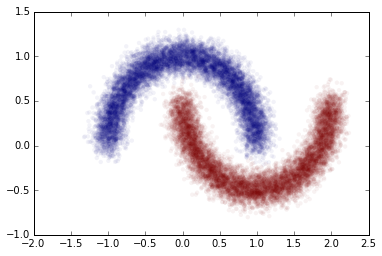

In [275]:
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.05, linewidths=0)

In [276]:
X_ = theano.shared(trainX, name='X')
y_ = theano.shared(trainY, name='y')
param = T.vector()

n_hidden_1 = 10
n_hidden_2 = 6

## Exercise

Write 2 hidden layers NN (use code from 1-hidden layer NN)

In [278]:
# TODO
# define loss here
# we pack all weights into one vector, and we need to extract matrix and vector from it



results = fit_predict_NN(trainX, trainY, testX, [T.nnet.sigmoid,T.nnet.sigmoid], [10,6])

In [282]:
roc_auc_score(testY, results)

0.99880082613755017

## Define special function for NNs

This function simplifies experiments with functions

In [273]:
def fit_predict_NN(trainX, trainY, testX, activate_functions, hidden_layers):
    X_ = theano.shared(trainX, name='X')
    y_ = theano.shared(trainY, name='y')
    param = T.vector()
    dim = X.shape[1]
    
    def activation(data_, parameter):
        n_previous = 0
        dim_previous = dim
        h = data_
        for n_hidden, func in zip(hidden_layers, activate_functions):
            N = dim_previous * n_hidden
            W_ = parameter[n_previous:n_previous + N].reshape((dim_previous, n_hidden))
            h = func(h.dot(W_))
            dim_previous = n_hidden
            n_previous += N

        # output     
        v_ = parameter[n_previous:]
        output = h.dot(v_)
        n_previous = n_previous + dim_previous
        
        return T.nnet.sigmoid(output), n_previous

    p_sig = activation(X_, param)[0]
    p_bck = 1 - p_sig
    llh_ = y_.dot(T.log(p_sig)) + (1 - y_).dot(T.log(p_bck))
    loss = -llh_
    
    # optimize
    loss_function = theano.function([param], loss)
    loss_grad = theano.function([param], theano.grad(loss, param))
    result = minimize(loss_function, jac=loss_grad, x0=numpy.random.normal(size=activation(X_, param)[1]))
    optimal_params = result['x']
    
    # predict data
    data = T.matrix()
    compiled_activation = theano.function([data, param], activation(data, param)[0])
    
    return compiled_activation(testX, optimal_params)

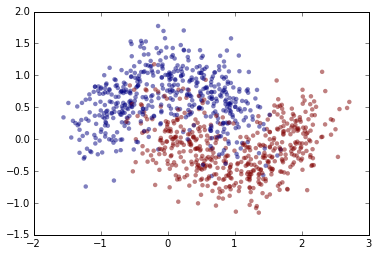

In [283]:
# generate another dataset with more noise
X, y = make_moons(n_samples=1000, noise=0.3)

trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, linewidths=0)

In [284]:
pred = fit_predict_NN(trainX, trainY, testX, [T.nnet.sigmoid] * 3, [20, 10, 5])
roc_auc_score(testY, pred)

0.85197363157810524

## Popular activation functions

* **Sigmoid**:

    $f(x) = \frac{1}  {1+e^{-x}}$


* **ReLU - rectifier linear unit**

    In the context of artificial neural networks, the rectifier is an activation function defined as

    $f(x) = \max(0, x)$

    where x is the input to a neuron. This activation function has been argued to be more biologically plausible than the widely used logistic sigmoid (which is inspired by probability theory; see logistic regression) and its more practical counterpart, the hyperbolic tangent. The rectifier is the most popular activation function for deep neural networks.

    A unit employing the rectifier is also called a rectified linear unit (ReLU).


* **Softplus**
    A smooth approximation to the rectifier is the analytic function

    $f(x) = \ln(1 + e^x)$

    which is called the softplus function.

## Exercise: 

Compare different intermediate activation functions:

* sigmoid (which we used, `T.nnet.sigmoid`)
* leaky ReLU (defined below)
* softplus (`T.nnet.softplus`)

In [285]:
def LeakyReLU(x):
    return T.switch(x > 0, x, 0.5 * x)

In [287]:
# TODO
pred = fit_predict_NN(trainX, trainY, testX, [T.nnet.softplus] * 3, [20, 10, 5])
roc_auc_score(testY, pred)


0.89893438295012706

In [289]:
pred = fit_predict_NN(trainX, trainY, testX, [LeakyReLU] * 3, [20, 10, 5])
roc_auc_score(testY, pred)

0.83627738043808708

## Multiclassification  Problem

In this case we need use `softmax` activation function for the last layer to get probabilities.


 * Exercise (optional): write multiclassification NN

## Neural Net interface in `hep_ml`

The only thing needed is to write activation function using `theano`

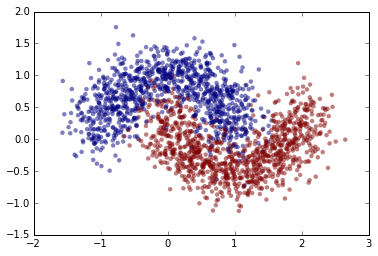

In [291]:
X, y = make_moons(n_samples=2000, noise=0.25, random_state=42)
trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.5, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, linewidths=0)

In [292]:
import hep_ml
from hep_ml import nnet
from hep_ml.nnet import AbstractNeuralNetworkClassifier

In [294]:
class SimpleNeuralNetwork(AbstractNeuralNetworkClassifier):
    def prepare(self):
        # getting number of layers in input, hidden, output layers
        # note that we support only one hidden layer here
        n1, n2, n3 = self.layers_
        
        # creating parameters of neural network
        W1 = self._create_matrix_parameter('W1', n1, n2)
        W2 = self._create_matrix_parameter('W2', n2, n3)
        
        # defining activation function
        def activation(input):
            first = T.nnet.sigmoid(T.dot(input, W1))
            return T.dot(first, W2)

        return activation

In [295]:
nnet_simple = SimpleNeuralNetwork()
nnet_simple.fit(trainX, trainY)

print roc_auc_score(testY, nnet_simple.predict_proba(testX)[:, 1])

0.95904937916


### Rewrite `SimpleNeuralNetwork` to support arbitrary number of layers 

Here is you don't need to add `b` parameter, this interface does it and includes additional column in `X`

In [296]:
class MyNeuralNetwork(AbstractNeuralNetworkClassifier):
    def prepare(self):
        # TODO
        
        def activation(input):
            # TODO

        return activation

IndentationError: expected an indented block (<ipython-input-296-f0d8795c49b7>, line 8)

In [ ]:
nnet_my = MyNeuralNetwork(layers=[15, 10, 5])
nnet_my.fit(trainX, trainY)

print roc_auc_score(testY, nnet_my.predict_proba(testX)[:, 1])

**Run the same code, results are very different (NN strongly depends on the initial parameters)**

In [ ]:
nnet_my = MyNeuralNetwork(layers=[15, 10, 5])
nnet_my.fit(trainX, trainY)
print roc_auc_score(testY, nnet_my.predict_proba(testX)[:, 1])

## NNs available in `hep_ml`
library has some examples of neural networks

In [297]:
from hep_ml.nnet import PairwiseNeuralNetwork, RBFNeuralNetwork, MLPClassifier

In [298]:
for models in [PairwiseNeuralNetwork(random_state=42), RBFNeuralNetwork(random_state=42), MLPClassifier(random_state=42)]:
    models.fit(trainX, trainY)
    pred = models.predict_proba(testX)[:, 1]
    print roc_auc_score(testY, pred)

0.944972478239
0.950416826677
0.94482046851


In [299]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=15)
knn_clf.fit(trainX, trainY)
print 'KNN', roc_auc_score(testY, knn_clf.predict_proba(testX)[:, 1])

log_clf = LogisticRegression(C=100)
log_clf.fit(trainX, trainY)
print 'logistic regression', roc_auc_score(testY, log_clf.predict_proba(testX)[:, 1])

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20)
rf_clf.fit(trainX, trainY)
print 'random forest', roc_auc_score(testY, rf_clf.predict_proba(testX)[:, 1])

gb_clf = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1)
gb_clf.fit(trainX, trainY)
print 'GB', roc_auc_score(testY, gb_clf.predict_proba(testX)[:, 1])

KNN 0.984262992832
logistic regression 0.944808467742
random forest 0.98048875128
GB 0.977748575909


# Bagging over NN - using sklearn's meta algorithms

In [300]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier

In [301]:
base = RBFNeuralNetwork()
meta_ada = AdaBoostClassifier(base_estimator=base, n_estimators=10, learning_rate=0.05, random_state=42)
meta_ada.fit(trainX, trainY)

print roc_auc_score(testY, meta_ada.predict_proba(testX)[:, 1])

0.977658570148


In [302]:
base = RBFNeuralNetwork()
meta_bagging = BaggingClassifier(base_estimator=base, n_estimators=50, max_samples=0.7, random_state=42)
meta_bagging.fit(trainX, trainY)

print roc_auc_score(testY, meta_bagging.predict_proba(testX)[:, 1])

0.970862135177


**Ok! This really works for simple datasets! Maybe try this for some other data? **

# NN in theanets

This also requires `theanets`and `rep` (latest shall be installed without dependencies, otherwise it is likely to downgrade some of libraries).

In [303]:
from rep.estimators import TheanetsClassifier

In [304]:
knn_clf = TheanetsClassifier(layers=[20, 10, 5], trainers=[{'algo': 'adadelta', 'learning_rate': 0.05}])
knn_clf.fit(trainX, trainY)

print 'Theanets', roc_auc_score(testY, knn_clf.predict_proba(testX)[:, 1])

Theanets 0.987691212238
